In [1]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import pandas as pd
from datasets import Dataset, DatasetDict, load_dataset, ClassLabel, concatenate_datasets
from sklearn.preprocessing import MultiLabelBinarizer
#Seeding for deterministic results
RANDOM_SEED = 64
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

if torch.cuda.is_available():
   torch.cuda.manual_seed(RANDOM_SEED)
   torch.cuda.manual_seed_all(RANDOM_SEED) 
   torch.backends.cudnn.deterministic = True  
   torch.backends.cudnn.benchmark = False

/home/njfernandez/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
comfunctions_basic = 'comfunct_basic.txt'
df = pd.read_csv(comfunctions_basic, delimiter=";")
df = df[df['function'].isin(['ANGRY', 'WORRIED', 'PESSIMISTIC', 'DISLIKE', 'OTHER'])].rename(columns={"function": "functions"})
df

,text,functions
85,I'm not really very keen on it,DISLIKE
86,I'm not really very keen,DISLIKE
87,I'm not really keen on it,DISLIKE
88,I'm not really keen,DISLIKE
89,I'm not very keen on it,DISLIKE
...,...,...
897,you could do it,OTHER
898,you look nice,OTHER
899,you look smart,OTHER
900,you're right,OTHER


In [3]:
unique_labels = df["functions"].unique().tolist()
function_labels = ClassLabel(names=unique_labels)

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit([function_labels.names])
labels_classes = mlb.classes_
labels_classes

array(['ANGRY', 'DISLIKE', 'OTHER', 'PESSIMISTIC', 'WORRIED'],
      dtype=object)

In [4]:
model_ckpt = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

def mean_pooling(model_output, attention_mask):   
    token_embeddings = model_output[0] 
    input_mask_expanded = (attention_mask
                           .unsqueeze(-1)
                           .expand(token_embeddings.size())
                           .float()) 
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9) 
    return sum_embeddings / sum_mask

def embed_text(examples):
    inputs = tokenizer(examples["text"], padding=True, truncation=True,
                       return_tensors="pt")
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

from sentence_transformers import util
def cosine_sim(batch):
    batch['predicted_labels'], batch['scores'] = [[] for _ in range(len(batch['text']))], [[] for _ in range(len(batch['text']))]
    for i, emb in enumerate(batch['embedding']):
        scores = {func: util.pytorch_cos_sim(emb, metaemb[func]).item() for func in metaemb}
        sorted_labels = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        sorted_labels, sorted_scores = zip(*sorted_labels)
        batch['predicted_labels'][i] = sorted_labels
        batch['scores'][i] = sorted_scores        
    return batch

In [5]:
def get_preds(example, threshold=None, topk=None):
    preds = []
    if threshold:
        for label, score in zip(example["predicted_labels"], example["scores"]):
            if score >= threshold:
                preds.append(label)
    elif topk:
        for i in range(topk):
            preds.append(example["predicted_labels"][i])
    else:
        raise ValueError("Set either `threshold` or `topk`.")
    return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}

from sklearn.metrics import classification_report
def get_clf_report(ds):
    y_true = np.array(ds["label_ids"])
    y_pred = np.array(ds["pred_label_ids"])
    return classification_report(
        y_true, y_pred, target_names=mlb.classes_, zero_division=0, 
        output_dict=True)

In [6]:
function_mapping = {'OTHER': ['anticipation', 'joy', 'love', 'optimism', 'surprise', 'trust'],
           'NOT_INTERESTED': [''], 
           'DISLIKE':['disgust'], 
           'NOT_CORRECT': [''], 
           'PESSIMISTIC':['sadness', 'pessimism'], 
           'WORRIED':['fear'], 
           'ANGRY': ['anger'], 
           'DISAPPOINTED': [''], 
           'BORED': [''], 
           'NOT_APPROVE':[''], 
           'NOT_IMPORTANT': [''], 
           'DISAGREE': [''], 
           'WARN': [''], 
           'COMPLAIN': [''], 
           'THREATEN': [''], 
           'UNWILLING': [''], 
           'DISTRUST' : [''],
           'REFUSE': [''] }

ait_es_dataset = load_dataset("csv", sep = '\t', data_files ={'train': r'2018-E-c-Es-train.txt',
                                                        'test': r'2018-E-c-Es-test-gold.txt',
                                                       'valid': r'2018-E-c-Es-dev.txt'})
ait_en_dataset = load_dataset("csv", sep = '\t', data_files ={'train': r'2018-E-c-En-train.txt',
                                                        'test': r'2018-E-c-En-test-gold.txt',
                                                       'valid': r'2018-E-c-En-dev.txt'})
ait_ar_dataset = load_dataset("csv", sep = '\t', data_files ={'train': r'2018-E-c-Ar-train.txt',
                                                        'test': r'2018-E-c-Ar-test-gold.txt',
                                                       'valid': r'2018-E-c-Ar-dev.txt'})
train_dataset = concatenate_datasets([ait_es_dataset['train'], ait_en_dataset['train'], ait_ar_dataset['train']])
valid_dataset = concatenate_datasets([ait_es_dataset['valid'], ait_en_dataset['valid'], ait_ar_dataset['valid']])
test_dataset = concatenate_datasets([ait_es_dataset['test'], ait_en_dataset['test'], ait_ar_dataset['test']])

ait_dataset = DatasetDict({'train': train_dataset.shuffle(seed=42), 'valid': valid_dataset.shuffle(seed=42), 'test': test_dataset.shuffle(seed=42)})

new_dataset = DatasetDict()
for split in ait_dataset:
    new_split = []
    for record in ait_dataset[split]:
        new_record = {'text': record['Tweet']}
        for function in function_mapping:
            labels = function_mapping[function]
            if '' in labels:
                continue
            else:
                score = sum([record[label] for label in labels])
                new_record[function] = int(score > 0)
        new_split.append(new_record)
    ait_dataset[split] =  Dataset.from_pandas(pd.DataFrame(data=new_split))
cols = ait_dataset['test'].column_names
ait_dataset = ait_dataset.map(lambda x : {"functions": [c for c in cols if x[c] == 1]})
# Convert labels to one hot enconding vectors
def one_hot_encoding(batch):
    label_ids = mlb.transform(batch['functions'])
    return {"label_ids":label_ids}
ait_dataset = ait_dataset.map(one_hot_encoding, batched=True)

def get_predicted_labels(batch):
    transformed_into_label_names = mlb.inverse_transform(np.array(batch['pred_label_ids']))
    return  {"predicted_labels": list(map(list, transformed_into_label_names))}

Using custom data configuration default-051610f9ffe8f8d2
Found cached dataset csv (/home/njfernandez/.cache/huggingface/datasets/csv/default-051610f9ffe8f8d2/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|██████████| 3/3 [00:00<00:00, 43.97it/s]
Using custom data configuration default-94907eb33ba58000
Found cached dataset csv (/home/njfernandez/.cache/huggingface/datasets/csv/default-94907eb33ba58000/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|██████████| 3/3 [00:00<00:00, 40.85it/s]
Using custom data configuration default-869e6abb15784ff2
Found cached dataset csv (/home/njfernandez/.cache/huggingface/datasets/csv/default-869e6abb15784ff2/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|██████████| 3/3 [00:00<00:00, 100.21it/s]
Loading cached shuffled indices for dataset at /home/njfernandez/.cache/huggingface/datasets/csv/default-051610f9ffe8f8d2/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a

# Function basic experiment

In [7]:
df["functions"] = df["functions"].apply(lambda x: [x])

In [8]:
dataset = DatasetDict({
    "train": Dataset.from_pandas(df.reset_index(drop=True)),
     "test": ait_dataset['test']
}
    )
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'functions'],
        num_rows: 410
    })
    test: Dataset({
        features: ['text', 'OTHER', 'DISLIKE', 'PESSIMISTIC', 'WORRIED', 'ANGRY', 'functions', 'label_ids'],
        num_rows: 7631
    })
})

In [9]:
dataset = dataset.map(embed_text, batched=True, batch_size=16)

100%|██████████| 477/477 [01:02<00:00,  7.66ba/s]


In [10]:
metaemb = {}

for i, functions in enumerate(dataset['train']['functions']):
    emb = torch.FloatTensor(dataset['train']['embedding'][i])
    for function in functions:
        if function not in metaemb:
            metaemb[function] = []
        
        metaemb[function].append(emb)

for key, value in metaemb.items():
    metaemb[key] = torch.stack(value)
    metaemb[key] = torch.mean(metaemb[key], dim=0)

print(metaemb.keys())

dict_keys(['DISLIKE', 'PESSIMISTIC', 'WORRIED', 'ANGRY', 'OTHER'])


In [11]:
metaemb['DISLIKE']

tensor([ 6.7538e-02,  1.3335e-01, -1.2454e-02, -2.7410e-02, -2.4313e-02,
         1.7517e-01,  4.0530e-02, -5.4710e-02,  2.2016e-02,  2.7840e-02,
        -5.9152e-03, -1.0522e-02, -7.8893e-02, -9.0480e-02, -1.2743e-01,
        -2.1452e-02, -9.0511e-03,  1.0107e-01,  1.2335e-01, -7.9975e-02,
        -1.4674e-02,  4.6716e-02,  7.9325e-02, -2.5987e-02,  5.6430e-03,
        -1.1473e-01,  1.3531e-01,  2.3348e-02,  4.1154e-02,  5.0528e-03,
         2.1741e-01, -2.6105e-02, -1.9900e-01,  2.0155e-02,  1.0432e-01,
         9.0955e-02,  5.0205e-02,  9.6020e-02, -2.6545e-02,  1.4623e-01,
         2.6646e-01,  8.5687e-02,  3.6279e-02,  5.9509e-02, -3.4850e-02,
        -7.4105e-02,  1.0791e-01,  3.3522e-02,  7.1783e-02, -7.7260e-02,
         6.4752e-02,  1.6176e-01, -1.8496e-01,  2.1648e-02,  1.4033e-01,
         8.0908e-02, -1.2508e-01, -1.7596e-02,  6.5109e-02, -9.4208e-02,
        -1.1379e-01, -6.1426e-02, -1.4919e-01,  2.1703e-02,  1.0802e-03,
         6.5309e-02,  7.3510e-02, -1.5441e-01,  1.2

In [12]:
dataset['test'] = dataset['test'].map(cosine_sim, batched=True, batch_size=16)

100%|██████████| 477/477 [00:05<00:00, 95.27ba/s]


In [13]:
dataset['test'][0]

{'text': '@kenjigi Jajaja ay soy iop vv :3 ',
 'OTHER': 1,
 'DISLIKE': 0,
 'PESSIMISTIC': 0,
 'WORRIED': 0,
 'ANGRY': 0,
 'functions': ['OTHER'],
 'label_ids': [0, 0, 1, 0, 0],
 'embedding': [0.09254460781812668,
  -0.12223748862743378,
  -0.010332224890589714,
  0.05245083570480347,
  0.21224606037139893,
  -0.01068186853080988,
  0.09743795543909073,
  0.10648743808269501,
  -0.010499273426830769,
  0.09674693644046783,
  0.01186428964138031,
  0.07578542828559875,
  0.07714784890413284,
  0.09643576294183731,
  0.031427957117557526,
  -0.06261083483695984,
  0.044450968503952026,
  0.16188758611679077,
  0.10364195704460144,
  0.06888695061206818,
  0.10649671405553818,
  0.009048023261129856,
  0.09221261739730835,
  0.05364375188946724,
  -0.14597824215888977,
  -0.013891155831515789,
  0.0033929443452507257,
  0.02467198111116886,
  -0.06842777878046036,
  0.0019570293370634317,
  -0.017263660207390785,
  -0.07304248958826065,
  -0.06670288741588593,
  -0.011770657263696194,
  0.

In [14]:
macros, micros, macroprecision, macrorecall = [], [], [], []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds:
    dataset['test'] = dataset['test'].map(get_preds,
                                    fn_kwargs={"threshold": threshold})
    clf_report = get_clf_report(dataset['test'])
    micros.append(clf_report["micro avg"]["f1-score"])
    macros.append(clf_report["macro avg"]["f1-score"])
    macroprecision.append(clf_report['macro avg']['precision'])
    macrorecall.append(clf_report['macro avg']['recall'])

100%|██████████| 7631/7631 [00:01<00:00, 4558.07ex/s]


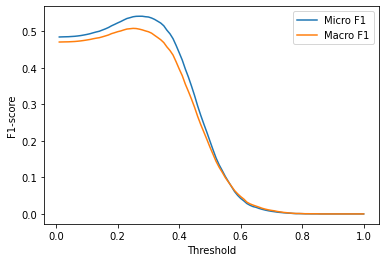

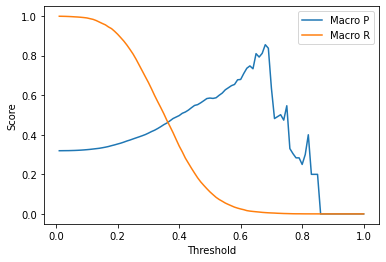

In [15]:
import matplotlib.pyplot as plt

plt.plot(thresholds, micros, label="Micro F1")
plt.plot(thresholds, macros, label="Macro F1")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()
plt.plot(thresholds, macroprecision, label="Macro P")
plt.plot(thresholds, macrorecall, label="Macro R")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

In [16]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f'Best threshold (micro): {best_t} with F1-score {best_micro:.2f}.')
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f'Best threshold (macro): {best_t} with F1-score {best_macro:.2f}.')
best_t, best_macro_P = thresholds[np.argmax(macroprecision)], np.max(macroprecision)
print(f'Best threshold (macro-Precision): {best_t} with macroP-score {best_macro_P:.2f}.')
best_t, best_macro_R = thresholds[np.argmax(macrorecall)], np.max(macrorecall)
print(f'Best threshold (macro-Recall): {best_t} with macroR-score {best_macro_R:.2f}.')

Best threshold (micro): 0.27 with F1-score 0.54.
Best threshold (macro): 0.25 with F1-score 0.51.
Best threshold (macro-Precision): 0.68 with macroP-score 0.86.
Best threshold (macro-Recall): 0.01 with macroR-score 1.00.


In [18]:
dataset['test'] = dataset['test'].map(get_preds, fn_kwargs={'threshold': 0.3})
clf_report = get_clf_report(dataset['test'])

100%|██████████| 7631/7631 [00:01<00:00, 4687.41ex/s]


In [19]:
print(clf_report)

{'ANGRY': {'precision': 0.4732789855072464, 'recall': 0.7949790794979079, 'f1-score': 0.5933286018452804, 'support': 2629}, 'DISLIKE': {'precision': 0.3017486783245222, 'recall': 0.40369967355821545, 'f1-score': 0.3453572259716081, 'support': 1838}, 'OTHER': {'precision': 0.5630077787381158, 'recall': 0.827489837398374, 'f1-score': 0.6700956691698385, 'support': 3936}, 'PESSIMISTIC': {'precision': 0.4593987075021073, 'recall': 0.6075808249721293, 'f1-score': 0.5232, 'support': 2691}, 'WORRIED': {'precision': 0.24429752066115704, 'recall': 0.6855287569573284, 'f1-score': 0.36022422617596883, 'support': 1078}, 'micro avg': {'precision': 0.4397734358761172, 'recall': 0.6952842589549786, 'f1-score': 0.5387700534759358, 'support': 12172}, 'macro avg': {'precision': 0.4083463341466297, 'recall': 0.6638556344767911, 'f1-score': 0.49844114463253913, 'support': 12172}, 'weighted avg': {'precision': 0.45304451116769173, 'recall': 0.6952842589549786, 'f1-score': 0.5445593941223494, 'support': 121

In [20]:
import pandas as pd

df = pd.DataFrame(clf_report).transpose()
with open(r'classification_report_functions_basic_ait_metaembedding.csv', 'w') as csv_file:
    df.to_csv(path_or_buf=csv_file)

In [21]:
dataset['test'] = dataset['test'].map(get_predicted_labels, batched=True)

dataset['test'].set_format("pandas")
cols = ["text", "functions", "predicted_labels"]
df_test = dataset['test'][:][cols]
df_test.to_csv('preds_functions_basic_ait_metaembedding.tsv',header =True, sep = '\t',index=False)

100%|██████████| 8/8 [00:00<00:00, 83.62ba/s]


In [23]:
df_test

,text,functions,predicted_labels
0,@kenjigi Jajaja ay soy iop vv :3,[OTHER],[OTHER]
1,Me esta doliendo la cabeza 🙁,"[PESSIMISTIC, ANGRY]","[ANGRY, DISLIKE, OTHER, PESSIMISTIC, WORRIED]"
2,٢٩ | رمضان 🌙 اللهم أجعل رمضان هذا العام خاتمه ...,[OTHER],[OTHER]
3,Remember what God says about you is most impor...,[OTHER],[OTHER]
4,Usually love @KatiePrice but watching #mycrazy...,"[DISLIKE, PESSIMISTIC, ANGRY]","[ANGRY, DISLIKE]"
...,...,...,...
7626,@AquaticQueenM -He laughs back- 'I may act all...,"[OTHER, PESSIMISTIC]","[ANGRY, DISLIKE, OTHER, PESSIMISTIC, WORRIED]"
7627,My arms and legs abs tummy and back and face a...,"[PESSIMISTIC, ANGRY]",[ANGRY]
7628,#muggymike #revenge oh dear,[ANGRY],"[ANGRY, DISLIKE, OTHER, PESSIMISTIC, WORRIED]"
7629,@LllDev ماله داعي تشهير شي بيني وبينك😤,"[DISLIKE, PESSIMISTIC, ANGRY]","[ANGRY, DISLIKE, OTHER, PESSIMISTIC, WORRIED]"


# Function extended experiment

In [24]:
comfunctions_extended = 'comfunct_extended.txt'
df = pd.read_csv(comfunctions_extended, delimiter=";")
df = df[df['function'].isin(['ANGRY', 'WORRIED', 'PESSIMISTIC', 'DISLIKE', 'OTHER'])].rename(columns={"function": "functions"})
df["functions"] = df["functions"].apply(lambda x: [x])
df

,text,functions
0,"Hey #friends, just wanted to clarify that the ...",[OTHER]
1,Good morning everyone! ☀️ Just wanted to say a...,[OTHER]
2,"Hey #team, don't forget our meeting at 2pm tod...",[OTHER]
3,"Sorry for the late reply, I was swamped at wor...",[OTHER]
4,"Hey, can someone introduce me to @jane_doe? I'...",[OTHER]
...,...,...
2106,i hate this,[DISLIKE]
2107,this is the worst,[DISLIKE]
2108,"Ew, spinach in my salad again. 😒 #NotAVegHead",[DISLIKE]
2109,🤢 Don't like this new food trend 🍔 #StickToThe...,[DISLIKE]


In [25]:
dataset = DatasetDict({
    "train": Dataset.from_pandas(df.reset_index(drop=True)),
     "test": ait_dataset['test']
}
    )
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'functions'],
        num_rows: 733
    })
    test: Dataset({
        features: ['text', 'OTHER', 'DISLIKE', 'PESSIMISTIC', 'WORRIED', 'ANGRY', 'functions', 'label_ids'],
        num_rows: 7631
    })
})

In [26]:
dataset = dataset.map(embed_text, batched=True, batch_size=16)

100%|██████████| 477/477 [01:01<00:00,  7.77ba/s]


In [27]:
metaemb = {}

for i, functions in enumerate(dataset['train']['functions']):
    emb = torch.FloatTensor(dataset['train']['embedding'][i])
    for function in functions:
        if function not in metaemb:
            metaemb[function] = []
        
        metaemb[function].append(emb)

for key, value in metaemb.items():
    metaemb[key] = torch.stack(value)
    metaemb[key] = torch.mean(metaemb[key], dim=0)

print(metaemb.keys())

dict_keys(['OTHER', 'ANGRY', 'WORRIED', 'PESSIMISTIC', 'DISLIKE'])


In [28]:
dataset['test'] = dataset['test'].map(cosine_sim, batched=True, batch_size=16)

100%|██████████| 477/477 [00:04<00:00, 96.08ba/s]


In [29]:
dataset['test'] 

Dataset({
    features: ['text', 'OTHER', 'DISLIKE', 'PESSIMISTIC', 'WORRIED', 'ANGRY', 'functions', 'label_ids', 'embedding', 'predicted_labels', 'scores'],
    num_rows: 7631
})

In [30]:
macros, micros, macroprecision, macrorecall = [], [], [], []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds:
    dataset['test'] = dataset['test'].map(get_preds,
                                    fn_kwargs={"threshold": threshold})
    clf_report = get_clf_report(dataset['test'])
    micros.append(clf_report["micro avg"]["f1-score"])
    macros.append(clf_report["macro avg"]["f1-score"])
    macroprecision.append(clf_report['macro avg']['precision'])
    macrorecall.append(clf_report['macro avg']['recall'])

100%|██████████| 7631/7631 [00:01<00:00, 4868.37ex/s]


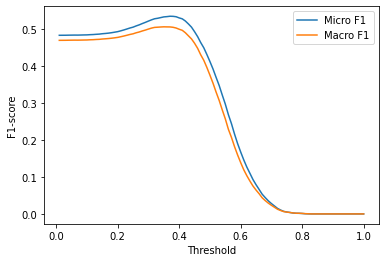

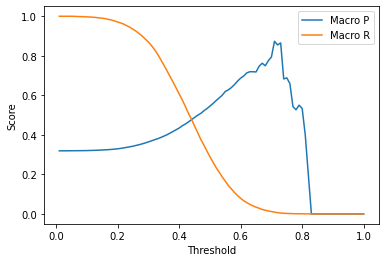

In [31]:
plt.plot(thresholds, micros, label="Micro F1")
plt.plot(thresholds, macros, label="Macro F1")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()
plt.plot(thresholds, macroprecision, label="Macro P")
plt.plot(thresholds, macrorecall, label="Macro R")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

In [32]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f'Best threshold (micro): {best_t} with F1-score {best_micro:.2f}.')
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f'Best threshold (macro): {best_t} with F1-score {best_macro:.2f}.')
best_t, best_macro_P = thresholds[np.argmax(macroprecision)], np.max(macroprecision)
print(f'Best threshold (macro-Precision): {best_t} with macroP-score {best_macro_P:.2f}.')
best_t, best_macro_R = thresholds[np.argmax(macrorecall)], np.max(macrorecall)
print(f'Best threshold (macro-Recall): {best_t} with macroR-score {best_macro_R:.2f}.')

Best threshold (micro): 0.37 with F1-score 0.54.
Best threshold (macro): 0.35000000000000003 with F1-score 0.51.
Best threshold (macro-Precision): 0.7100000000000001 with macroP-score 0.87.
Best threshold (macro-Recall): 0.01 with macroR-score 1.00.


In [34]:
dataset['test'] = dataset['test'].map(get_preds, fn_kwargs={'threshold': 0.4})
clf_report = get_clf_report(dataset['test'])

100%|██████████| 7631/7631 [00:01<00:00, 4644.66ex/s]


In [35]:
print(clf_report)

{'ANGRY': {'precision': 0.47607655502392343, 'recall': 0.6812476226702168, 'f1-score': 0.5604756689094037, 'support': 2629}, 'DISLIKE': {'precision': 0.3240906380441264, 'recall': 0.5914036996735582, 'f1-score': 0.41872110939907553, 'support': 1838}, 'OTHER': {'precision': 0.6437530149541727, 'recall': 0.678099593495935, 'f1-score': 0.6604800791883197, 'support': 3936}, 'PESSIMISTIC': {'precision': 0.474047404740474, 'recall': 0.5871423262727611, 'f1-score': 0.5245683930942896, 'support': 2691}, 'WORRIED': {'precision': 0.25514600287218764, 'recall': 0.49443413729128016, 'f1-score': 0.3365961477739185, 'support': 1078}, 'micro avg': {'precision': 0.4591225125869096, 'recall': 0.6293131777850806, 'f1-score': 0.5309121153313002, 'support': 12172}, 'macro avg': {'precision': 0.43462272312697686, 'recall': 0.6064654758807502, 'f1-score': 0.5001682796730014, 'support': 12172}, 'weighted avg': {'precision': 0.48733196516558136, 'recall': 0.6293131777850806, 'f1-score': 0.543642270575137, 'su

In [36]:
df = pd.DataFrame(clf_report).transpose()
with open(r'classification_report_functions_extended_ait_metaembedding.csv', 'w') as csv_file:
    df.to_csv(path_or_buf=csv_file)

In [39]:
dataset['test'] = dataset['test'].map(get_predicted_labels, batched=True)

dataset['test'].set_format("pandas")
cols = ["text", "functions", "predicted_labels"]
df_test = dataset['test'][:][cols]
df_test.to_csv('preds_functions_extended_ait_metaembedding.tsv',header =True, sep = '\t',index=False)

  0%|          | 0/8 [00:00<?, ?ba/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_2791221/3265877211.py:1 in <module>                                               │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_2791221/3265877211.py'                      │
│                                                                                                  │
│ /home/njfernandez/.local/lib/python3.8/site-packages/datasets/arrow_dataset.py:2826 in map       │
│                                                                                                  │
│   2823 │   │   disable_tqdm = not logging.is_progress_bar_enabled()                              │
│   2824 │   │                                                                                     │
│   2825 │   │   if num_proc is None or num_proc == 1:                                             │
│ ❱ 2826 │   │   │   return self._map_single(                                                      │
│   2827 │   │   │   │   function=function,                                                        │
│   2828 │   │   │   │   with_indices=with_indices,                                                │
│   2829 │   │   │   │   with_rank=with_rank,                                                      │
│                                                                                                  │
│ /home/njfernandez/.local/lib/python3.8/site-packages/datasets/arrow_dataset.py:562 in wrapper    │
│                                                                                                  │
│    559 │   │   else:                                                                             │
│    560 │   │   │   self: "Dataset" = kwargs.pop("self")                                          │
│    561 │   │   # apply actual function                                                           │
│ ❱  562 │   │   out: Union["Dataset", "DatasetDict"] = func(self, *args, **kwargs)                │
│    563 │   │   datasets: List["Dataset"] = list(out.values()) if isinstance(out, dict) else [ou  │
│    564 │   │   for dataset in datasets:                                                          │
│    565 │   │   │   # Remove task templates if a column mapping of the template is no longer val  │
│                                                                                                  │
│ /home/njfernandez/.local/lib/python3.8/site-packages/datasets/arrow_dataset.py:529 in wrapper    │
│                                                                                                  │
│    526 │   │   │   "output_all_columns": self._output_all_columns,                               │
│    527 │   │   }                                                                                 │
│    528 │   │   # apply actual function                                                           │
│ ❱  529 │   │   out: Union["Dataset", "DatasetDict"] = func(self, *args, **kwargs)                │
│    530 │   │   datasets: List["Dataset"] = list(out.values()) if isinstance(out, dict) else [ou  │
│    531 │   │   # re-apply format to the output                                                   │
│    532 │   │   for dataset in datasets:                                                          │
│                                                                                                  │
│ /home/njfernandez/.local/lib/python3.8/site-packages/datasets/fingerprint.py:480 in wrapper      │
│                                                                                                  │
│   477 │   │   │                                                                                  │
│   478 │   │   │   # Call actual function                                                         │
│   479 │   │   │                                            

# GoEmotions train (baseline) experiment

In [40]:
dataset = DatasetDict({
    "train": ait_dataset['train'],
     "test": ait_dataset['test']
}
    )
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'OTHER', 'DISLIKE', 'PESSIMISTIC', 'WORRIED', 'ANGRY', 'functions', 'label_ids'],
        num_rows: 12675
    })
    test: Dataset({
        features: ['text', 'OTHER', 'DISLIKE', 'PESSIMISTIC', 'WORRIED', 'ANGRY', 'functions', 'label_ids'],
        num_rows: 7631
    })
})

In [41]:
dataset = dataset.map(embed_text, batched=True, batch_size=16)

100%|██████████| 477/477 [01:01<00:00,  7.70ba/s]


In [ ]:
metaemb = {}

for i, functions in enumerate(dataset['train']['functions']):
    emb = torch.FloatTensor(dataset['train']['embedding'][i])
    for function in functions:
        if function not in metaemb:
            metaemb[function] = []
        
        metaemb[function].append(emb)

for key, value in metaemb.items():
    metaemb[key] = torch.stack(value)
    metaemb[key] = torch.mean(metaemb[key], dim=0)

print(metaemb.keys())

In [ ]:
dataset['test'] = dataset['test'].map(cosine_sim, batched=True, batch_size=16)

In [49]:
macros, micros, macroprecision, macrorecall = [], [], [], []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds:
    dataset['test'] = dataset['test'].map(get_preds,
                                    fn_kwargs={"threshold": threshold})
    clf_report = get_clf_report(dataset['test'])
    micros.append(clf_report["micro avg"]["f1-score"])
    macros.append(clf_report["macro avg"]["f1-score"])
    macroprecision.append(clf_report['macro avg']['precision'])
    macrorecall.append(clf_report['macro avg']['recall'])

100%|██████████| 7631/7631 [00:01<00:00, 4796.25ex/s]


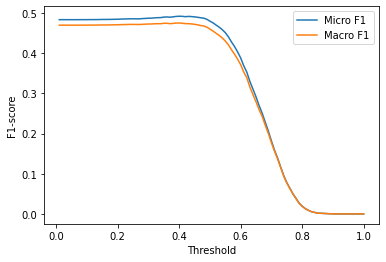

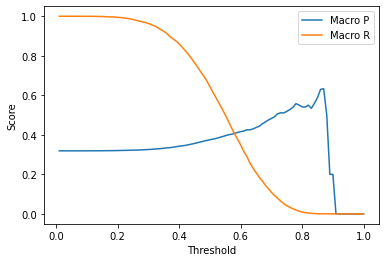

In [50]:
plt.plot(thresholds, micros, label="Micro F1")
plt.plot(thresholds, macros, label="Macro F1")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()
plt.plot(thresholds, macroprecision, label="Macro P")
plt.plot(thresholds, macrorecall, label="Macro R")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

In [51]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f'Best threshold (micro): {best_t} with F1-score {best_micro:.2f}.')
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f'Best threshold (macro): {best_t} with F1-score {best_macro:.2f}.')
best_t, best_macro_P = thresholds[np.argmax(macroprecision)], np.max(macroprecision)
print(f'Best threshold (macro-Precision): {best_t} with macroP-score {best_macro_P:.2f}.')
best_t, best_macro_R = thresholds[np.argmax(macrorecall)], np.max(macrorecall)
print(f'Best threshold (macro-Recall): {best_t} with macroR-score {best_macro_R:.2f}.')

Best threshold (micro): 0.4 with F1-score 0.49.
Best threshold (macro): 0.4 with F1-score 0.48.
Best threshold (macro-Precision): 0.87 with macroP-score 0.63.
Best threshold (macro-Recall): 0.01 with macroR-score 1.00.


In [52]:
dataset['test'] = dataset['test'].map(get_preds, fn_kwargs={'threshold': 0.4})
clf_report = get_clf_report(dataset['test'])

100%|██████████| 7631/7631 [00:01<00:00, 4609.28ex/s]


In [53]:
print(clf_report)

{'ANGRY': {'precision': 0.381594275253786, 'recall': 0.8721947508558388, 'f1-score': 0.5309099328548275, 'support': 2629}, 'DISLIKE': {'precision': 0.2607449856733524, 'recall': 0.8416757344940152, 'f1-score': 0.3981469566336378, 'support': 1838}, 'OTHER': {'precision': 0.5476918127714332, 'recall': 0.8650914634146342, 'f1-score': 0.6707377129912341, 'support': 3936}, 'PESSIMISTIC': {'precision': 0.37047573889679153, 'recall': 0.8710516536603493, 'f1-score': 0.5198491905078731, 'support': 2691}, 'WORRIED': {'precision': 0.15200399135207052, 'recall': 0.8478664192949907, 'f1-score': 0.25779156677478493, 'support': 1078}, 'micro avg': {'precision': 0.3443719466212007, 'recall': 0.8628820243181071, 'f1-score': 0.4922781280026247, 'support': 12172}, 'macro avg': {'precision': 0.34250216078948675, 'recall': 0.8595760043439657, 'f1-score': 0.4754870719524715, 'support': 12172}, 'weighted avg': {'precision': 0.39426438748167797, 'recall': 0.8628820243181071, 'f1-score': 0.5294440879675789, 's